In [3]:
import pandas as pd

df2 = pd.read_csv('labeled_data.csv')
df2.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df2.info()
df2.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [5]:
import pandas as pd

df = pd.read_csv('labeled_data.csv', encoding='latin1')
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


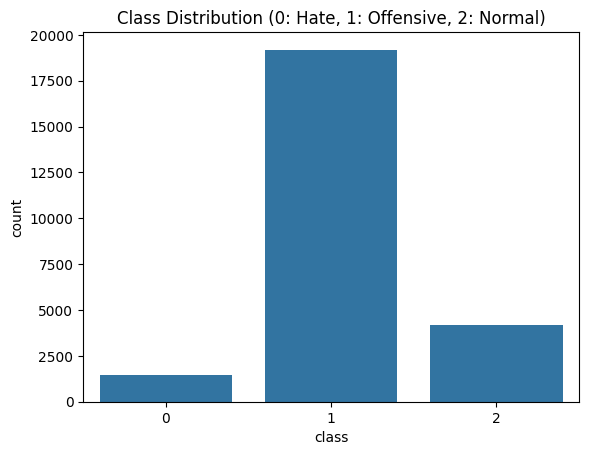

class
1    77.432111
2    16.797805
0     5.770084
Name: proportion, dtype: float64

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='class', data=df)
plt.title('Class Distribution (0: Hate, 1: Offensive, 2: Normal)')
plt.show()

df['class'].value_counts(normalize=True) * 100


In [7]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text.strip()

df['clean_text'] = df['tweet'].apply(clean_text)
df[['tweet', 'clean_text']].head()


,tweet,clean_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cle...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat h...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she sta...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true o...


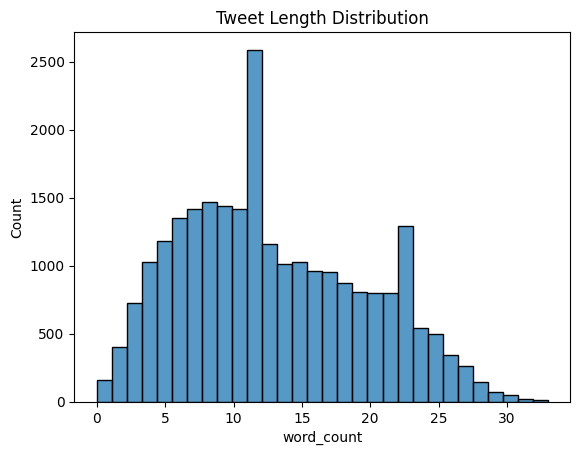

class
0    12.666434
1    12.734080
2    13.477540
Name: word_count, dtype: float64

In [8]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

sns.histplot(df['word_count'], bins=30)
plt.title('Tweet Length Distribution')
plt.show()

df.groupby('class')['word_count'].mean()


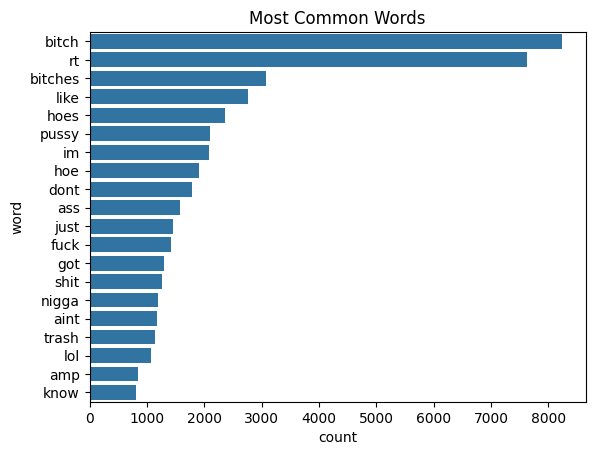

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer(stop_words='english', max_features=20)
X = cv.fit_transform(df['clean_text'])
word_freq = np.array(X.sum(axis=0)).flatten()
words = cv.get_feature_names_out()

freq_df = pd.DataFrame({'word': words, 'count': word_freq}).sort_values(by='count', ascending=False)
sns.barplot(x='count', y='word', data=freq_df)
plt.title('Most Common Words')
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["class"]   # Davidson uses the "class" column (0,1,2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = round(accuracy_score(y_test, y_pred), 3)
    f1  = round(f1_score(y_test, y_pred, average="macro"), 3)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("F1-score:", f1)



Logistic Regression
Accuracy: 0.891
F1-score: 0.671

Naive Bayes
Accuracy: 0.835
F1-score: 0.489

SVM (LinearSVC)
Accuracy: 0.886
F1-score: 0.684


In [13]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "C": [0.1, 1, 5, 10],
    "penalty": ["l2"],
    "max_iter": [300]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_grid_lr,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train_tfidf, y_train)

print("Best LR Params:", grid_lr.best_params_)
print("Best LR Mean F1:", round(grid_lr.best_score_, 3))

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

lr_optimized_acc = round(accuracy_score(y_test, y_pred_lr), 3)
lr_optimized_f1 = round(f1_score(y_test, y_pred_lr, average='macro'), 3)

print("Optimized LR Accuracy:", lr_optimized_acc)
print("Optimized LR F1:", lr_optimized_f1)


Best LR Params: {'C': 10, 'max_iter': 300, 'penalty': 'l2'}
Best LR Mean F1: 0.703
Optimized LR Accuracy: 0.885
Optimized LR F1: 0.684


In [14]:
param_grid_svm = {
    "C": [0.1, 1, 5, 10]
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_svm.fit(X_train_tfidf, y_train)

print("Best SVM Params:", grid_svm.best_params_)
print("Best SVM Mean F1:", round(grid_svm.best_score_, 3))

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_tfidf)

svm_optimized_acc = round(accuracy_score(y_test, y_pred_svm), 3)
svm_optimized_f1 = round(f1_score(y_test, y_pred_svm, average='macro'), 3)

print("Optimized SVM Accuracy:", svm_optimized_acc)
print("Optimized SVM F1:", svm_optimized_f1)


Best SVM Params: {'C': 1}
Best SVM Mean F1: 0.698
Optimized SVM Accuracy: 0.886
Optimized SVM F1: 0.684


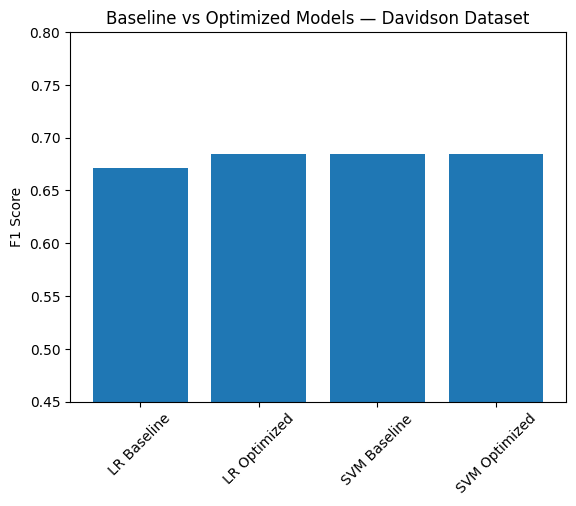

In [15]:
import matplotlib.pyplot as plt

models = [
    "LR Baseline", "LR Optimized",
    "SVM Baseline", "SVM Optimized"
]

scores = [
    0.671, lr_optimized_f1,   # 0.684
    0.684, svm_optimized_f1   # 0.684
]

plt.bar(models, scores)
plt.ylabel("F1 Score")
plt.title("Baseline vs Optimized Models — Davidson Dataset")
plt.xticks(rotation=45)
plt.ylim(0.45, 0.80)
plt.show()
